In [13]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv
/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTest.csv
/kaggle/input/for-simple-exercises-time-series-forecasting/Miles_Traveled.csv
/kaggle/input/for-simple-exercises-time-series-forecasting/Alcohol_Sales.csv
/kaggle/input/for-simple-exercises-time-series-forecasting/BeerWineLiquor.csv
/kaggle/input/for-simple-exercises-time-series-forecasting/energydata_complete.csv
/kaggle/input/for-simple-exercises-time-series-forecasting/prophet_facebook2.png
/kaggle/input/for-simple-exercises-time-series-forecasting/Deep Learning for Time Series Forecasting.png


In [14]:
from statsmodels.tsa.statespace.structural import UnobservedComponents
import pandas as pd
import numpy as np
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

from statsmodels.tsa.stattools import adfuller

from sklearn import tree

import warnings
warnings.filterwarnings("ignore")

## Modelos de Regressão aplicados em Séries Temporais

Como regra geral, modelos tradicionais de regressão pressupoem que as a observações do problema são **Independentes e Identicamente distribuidas.**

A **Independencia** afirma que a informação de uma amostra não fornece informações sobre outras amostras, enquanto a parte sobre **Identicamente Distribuidas** afirma que a distribuição das variaveis de entrada (ou independentes) e a distribuição da variavel de saida (ou dependente) são obtidas a partir de uma mesma distribuição para todas as observações.

### **Sobre a independencia das observações**

    É bastante comum que as amostras em séries temporais não sejam independentes e apresentem dependencia temporal, ou seja, que ao saber as caracteristicas de uma observação isso tambem fornece informação sobre outras observações da série temporal.
    
    Isso acontece por diversas razões. Por exemplo, em séries temporais ligadas a questões economicas, o efeito de questões como inflação, desemprego ou outras questões do cenário macroeconomico pode afetar os valores da série - com observações próximas no tempo compartilhando aproximadamente uma inflação/taxa de desemprego/variaveis macroeconomicas em comum, que variam de comportamento pelo restante da série.
     
    Essa violação no pressuposto da independencia, utilizado pelos modelos tradicionais de regressão, costuma enviesar as estimativas produzidas por modelos de regressão em séries temporais e gerar autocorrelação nos erros obtidos para observações próximas no tempo. 
    
    Seguindo no exemplo de uma série temporal relacionada a questões economicas, dado um erro cometido pelo modelo no instante T, devido a inflação/desemprego/variaveis macroeconomicas, podemos supor que essa variaveis continuarão atuando sobre as observações do modelo em T+1 e portanto o erro em T+1 terá semelhanças com o erro em T.

    Os modelos de séries temporais, por outro lado, costumam buscar modelar essas dependencia temporal, de forma com que a dependencia entre as observações possa ser quantificada e utilizada para gerar melhores estimativas sobre as observações futuras e comportamento geral da série.

In [15]:
df1 = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
df1['date'] = df1['date'].apply(lambda a : a.replace('-', ''))
df1['date'] = pd.to_datetime(df1['date'], format = '%Y%m%d')

df1 = df1.set_index('date')

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

lin_reg.fit(X = df1[['humidity', 'wind_speed', 'meanpressure']].iloc[:1100],y = df1['meantemp'].iloc[:1100])

forecast = lin_reg.predict(df1[['humidity', 'wind_speed', 'meanpressure']].iloc[1100:])
forecast = pd.Series(forecast, index = df1.iloc[1100:].index)

residual = df1['meantemp'].iloc[1100:] - forecast

### **Sobre o carater identicamente distribuido das observações**   
   
   
    Existem duas abordagens gerais de metodos de Machine Learning para os problemas de classificação/regressão. Uma das abordagens é utilizando metodologias parametricas, enquanto a outra utiliza metodologias não paramétricas.

    As metodologias paramétricas assumem pressupostos fixos sobre qual é a função que consegue descrever a relação entre as variaveis independentes e dependentes. Por exemplo, uma regressão linear assume que uma reta consegue descrever a relação entre a variavel de entrada e saida, produzindo apenas essa forma de relação para relacionar essas informações.

    Pressupostos simplificam o processo de aprendizagem, diminuindo a quantidade de observações necessárias para obter boas estimativas, mas tambem limitam as relações que podem ser estabelecidas entre Variaveis de Entrada e de Saida

    Já os métodos não paramétricos não assumem uma forma de relação pré-definida para relação entre entrada/saida, conseguindo se adaptar a formas variadas, como relações não-lineares, interações entre variaveis, etc. São os tipos de algoritmos mais utilizados em ambientes de Big data, devido a essa maior flexibilidade permitir mais facilidade para obtenão de performances ótimas nas estimativas.

    Embora os métodos não-parametricos em geral tenham maior performance, existem duas questões consideraveis que complicam sua utilização em séries temporais.

    A primeira é que ao não presumir uma relação especifica entre as variaveis de entrada e saida, esses métodos não costumam apresentar capacidade de extrapolação para valores de entrada/saida que não estejam contidos dentro dos intervalos de treinamento.

    Em problemas usuais de regressão, esse elemento pode apresentar inconvenientes ocasionais ao lidar com outliers. Porem ao lidar com séries temporais, esse elemento assume uma importancia fundamental, dado que é bastante comum que os valores entrada/saida de uma série temporal ocorram em intervalos não observados anteriormente. 

    Isso ocorre devido a tendencias de crescimento/decrescimento nos valores, assim como sazonalidades e periodos de ciclos de crescimento/decrescimento afetando os valores das observações.

    A segunda questão é que métodos não paramétricos costumam exigir quantidades maiores de informações do que métodos paramétricos para estabelecer boas estimativas, o que usualmente é um problema em séries temporais.

    Se um modelo de regressão for utilizado para um indicador gerado mensalmente, mesmo que esse indicador seja registrado por 10 anos, só teriamos 120 observações disponiveis para treino/teste/validação. 

    Mesmo se o indicador for gerado semanalmente, o salto no tamanho de amostras ainda não é enorme e conforme a granularidade aumenta, com indicadores gerados semanalmente/diariamente/horariamente, multiplas sazonalidades passam a poder impactar as observações (sazonalidade do dia da semana, semana do mês, mês do ano, hora do dia), se juntando na complicação anteriormente apresentada sobre extrapolação.
 

In [16]:
profundidade = 3

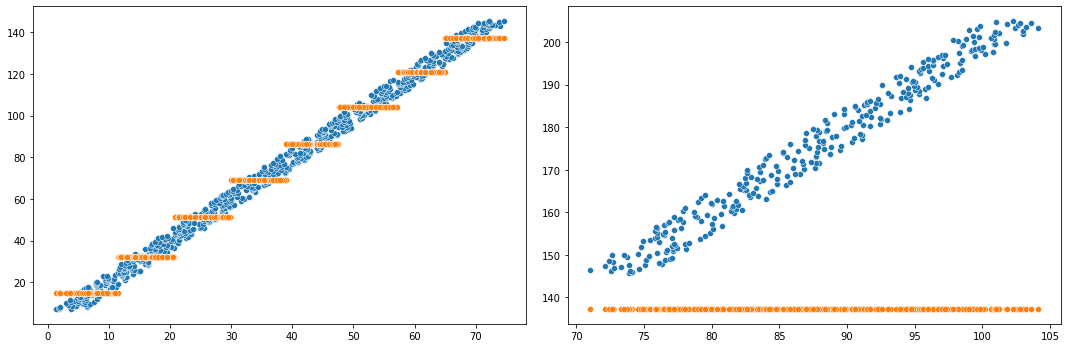

In [17]:
x = np.linspace(1, 100, 1000)

y = (x * 2) + 5

x = x  + np.random.rand(1000) * 5

regressor = tree.DecisionTreeRegressor(max_depth = profundidade)

regressor.fit(x[:700].reshape(-1, 1), y[:700])
prediction_train = regressor.predict(x[:700].reshape(-1, 1))
prediction_test = regressor.predict(x[700:].reshape(-1, 1))


figure, axes = plt.subplots(ncols = 2, figsize = (15, 5))

figure.tight_layout()



sns.scatterplot(x = x[:700], y = y[:700], ax = axes[0]);
sns.scatterplot(x = x[:700], y = prediction_train, ax = axes[0]);


sns.scatterplot(x = x[700:], y = y[700:], ax = axes[1]);
sns.scatterplot(x = x[700:], y = prediction_test, ax = axes[1]);

## Questões de Modelos de Séries Temporais


### Séries Estacionárias

    É bastante comum que modelos e técnicas voltados para séries temporais tenham como pressuposto que a série analisada seja **estacionária**, que significa que caracteristicas como a média e a variancia da séries são constantes pelo tempo.

    A importancia disso vem do fato de que diversas propriedades validas para observações geradas de maneira **Independente e Identicamente Distribuida** tambem são válidos para **Processos Estacionários** em que as observações são geradas de maneira **Dependente** (dois exemplos importantes são a lei dos grandes numeros e o teorema do limite central).

    Na realidade, é extremamente comum que as séries com que trabalhamos não sejam estacionárias e que sejam aplicadas transformações que as tornem estacionárias. A metodologia mais comum é a diferenciação da série, em que a cada valor Y da série momento t é subtraido do valor Y no momento t-1.

    Essa transformação faz com que os valores da série original em T e T+1 sejam convertidos na variação de T para T+1 e T+1 para T+2. Isso costuma produzir séries estacionárias ao custo de perda de informação contida na série original, sobre os níveis anteriores em cada momento T e o quanto essa variação representa proporcionalmente ao nivel anterior.

    Em situações em que toda ou quase toda informação está contina na variação entre cada momento no tempo, essa perda de informação tem pouco peso. Em situações em que o nivel anterior no momento T e a proporção de variação em relação ao nivel anterior importa, isso pode gerar impactos maiores sobre as estimativas. 

    Segue abaixo exemplo de situação em que a variação do valor 1 para 2, no instante T=0 para T = 1, é equivalente a variação de 100 para 101, no instante T = 12 para T = 13. Analogamente, a variação de 10 para 9, no instante T = 2 para T = 3, e a variação de 101 para 100, no instante T = 13 para T = 14, geram numeros equivalentes na série diferenciada.

,Serie Original,Serie Diferenciada
0,1,NaN
1,2,1.0
2,10,8.0
3,9,-1.0
4,15,6.0
5,30,15.0
6,25,-5.0
7,50,25.0
8,72,22.0
9,84,12.0


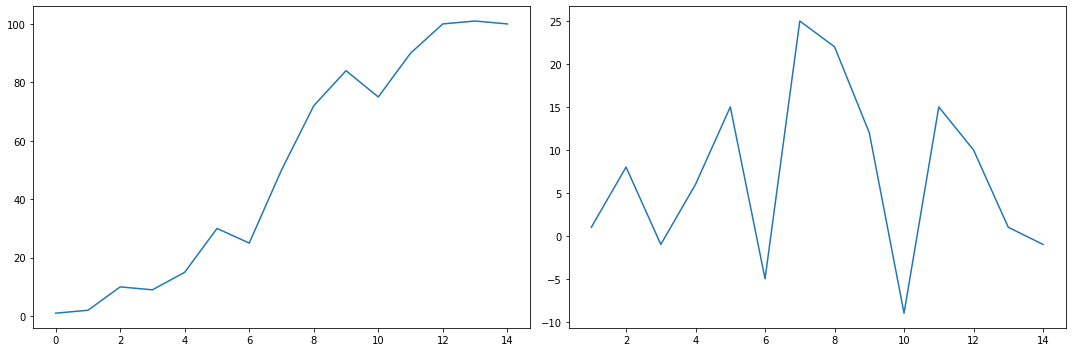

In [18]:
from statsmodels.tsa.stattools import adfuller

serie_original = pd.Series([1, 2, 10, 9, 15, 30, 25, 50, 72, 84, 75, 90, 100, 101, 100])
serie_original.name = 'Serie Original'

serie_diferenciada = serie_original.diff()
serie_diferenciada.name = 'Serie Diferenciada'

figure, axes = plt.subplots(ncols=2, figsize=(15, 5))
axes[0].plot(serie_original)
axes[1].plot(serie_diferenciada)
figure.tight_layout()

pd.concat([serie_original , serie_diferenciada], axis = 1)


#adfuller(serie_original.dropna())

#adfuller(serie_diferenciada.dropna())

### Interpretabilidade e performance

Um dos tipos de modelos mais utilizados devido a sua eficiencia e relativa simplicidade para construção são modelos **Autoregressivos (AR)**, que estima valores futuros a partir de uma combinação linear dos P valores anteriores, e modelos de **Médias Moveis (MA)**, em que os residuos dos ultimos Q pontos (obtidos pela diferença entre valor realizado e valor estimado) são ponderados.

Conforme são utilizados isoladamente e com ordem baixa nos valores de P e Q, esses modelos são consideravelmente interpretaveis; porem, conforme precisamos modelar séries mais elaboradas, a situação se complica de maneira bastante rápida ao exigir desde modelos ARIMA até SARIMAX.

Mesmo em casos de um ARIMA relativamente simples, o modelo já pode ser construido de maneira poquissimo intuitiva e hermética em relação a série original. Por exemplo, um modelo ARIMA (0,1,2) significa que os forecasts são gerados por uma média movel de ordem 2 dos residuos na série de diferenças, em relação aos valores originais.

Mesmo reformulando, para tentar aumentar a clareza, sobre o significado desse modelo ARIMA (0,1,2) uma dificuldade relativa se mantem para perceber quais relações diretas existem entre esse modelo e os valores da série original. Quando chegamos em situações com SARIMAX, essa questão já assume outro nivel na complexidade e perda de interpretabilidade/insight sobre a relação do modelo com os valores da série original.

Um exemplo, um tanto próximo, seria a tentativa de apresentar de forma clara essa mesma relação ao utilizar um modelo SARIMAX (1,1,2)(1,1,0)12. O interessante de se notar é que embora esse modelo já tenha uma complexidade grande, a construção de uma série para qual ele seja necessário pode ser feita de maneira bastante simples.

Os entraves e possibilidades relacionados a complexidade ou interpretabilidade dos modelos, fornecendo um insight sobre o comportamento da série original, dão ainda outro salto conforme se migra para o uso de redes neurais para estimação dessas séries.

## Unobserved Components Models

Uma abordagem bastante interessante para modelar séries temporais é a de **Unobserved Components Models**, que assume que poder modelar a série a partir da soma de diversos componentes, gerados de maneira a serem interpretaveis diretamente na relação com a série original.

\begin{equation}
y_{t}=μ_{t}+γ_{t}+ψ_{t}+βX+ε_{t}
\end{equation}

O primeiro componente é o **Nivel** da série, que pode ser entendido como o termo de intercepto correspondente a essa série temporal no instante T.

Como parte desse componente, temos tambem a **Tendencia**, que é entendido como a dinamica de crescimento/decrescimento no **Nível** da série a cada nova movimentação de T para T+1.

\begin{equation}
Y_{t}=a_{t-1}+b_{t-1}+σ_{t-1}
\end{equation}

\begin{equation}
b_{t}=b_{t-1}+ξ_{t-1}
\end{equation}


O segundo termo é a **Sazonalidade**, que é entendido como um componente com periodicidade definida, em que a influencia de cada estação no valor da série soma zero ao considerarmos todas estações em um ciclo completo de sazonalidade - é possivel que multiplas sazonalidades (diaria, semanal, mensal, anual, etc) componham esse componente.

O terceiro termo é o **Ciclo**, que é entendido como um componente voltado a capturar ciclos que impactem na série tenham periodicidade não tão rigidamente definida quanto as obtidas sazonalmente.

O quarto termo são os **Regressores Externos**, que são entendidas como variaveis externas a série, que são utilizadas para sua estimação.

O quinto termo é o **Residuo**, que pode ser construido a partir da correlação do erro em T+1 com o erro em T ou então apenas utilizando a diferença entre os valores realizados e estimados, independentemente em cada momento da série, durante sua modelagem.

- A manipulação dos componentes acima fornece insight sobre a série e informação para Analise Exploratória da série temporal, assim como permite adicionar conhecimento externo a partir de priors para modelagem do problema.

- A flexibilidade do modelo permite que cada um dos termos acima seja adicionado ou não de maneira independente, com cada um podendo ser estimado de maneira puramente deterministica ou então junto a um comportamento estocastico, que permite a evolução do comportamento do componente no tempo.

- A flexiblidade dos componentes que compoe a série + seu carater deterministico/estocastico permitem a simplificação ou a complexificação do modelo ao lidar com diferentes séries temporais. O uso de mais termos e seu carater estocastico possibilita a construção de modelos mais complexo, em que seus diversos componentes evoluam no tempo e acompanham a dinamica da série; assim como os modelos podem ser construidos de maneira bastante parcimoniosa e regularizada ao lidar com séries curtas/simples, com poucos componentes sendo utilizados nessa modelagem e com comportamentos mais fixados.

- Por um lado, isso permite que o modelo ganhe performance ao modelar séries longas, o que não necessariamente ocorre em outros modelos de séries tempories temporais que não adquirem mais ganho conforme avançados para alem de séries curtas/médias; por outro lado, cada componente permite ter sua significancia estatistica testada, o que é uma caracteristica relativamente importante ao lidar com séries com poucas observações.

- Dados esses diversos componentes e sua capacidade de ovolução pelo tempo, o modelo é estruturado de maneira a modelar diretamente o comportamento de **processos não estacionarios**, sem a necessidade de transformação da série original e estacionarização para isso.

# Na prática

In [43]:
df1 = pd.read_csv('/kaggle/input/daily-climate-time-series-data/DailyDelhiClimateTrain.csv')
df1['date'] = df1['date'].apply(lambda a : a.replace('-', ''))
df1['date'] = pd.to_datetime(df1['date'], format = '%Y%m%d')

df1 = df1.set_index('date')

print('Formato do dataframe é : ' + str(df1.shape))
df1.head()

Formato do dataframe é : (1462, 4)


,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


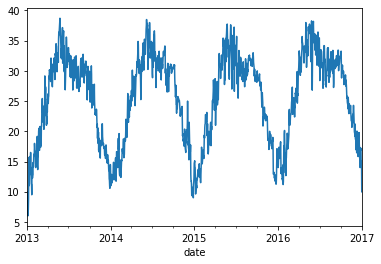

In [44]:
df1['meantemp'].plot();

In [45]:
model = {

'level' : False,
'stochastic_level' : False,
    
'trend' : False,
'stochastic_trend' : False,
    
'seasonal' : None, #numerico indicando qual a sazonalidade
'freq_seasonal' : None,
'stochastic_seasonal' : False,
'stochastic_freq_seasonal' : None,
    
'cycle' : False,
'stochastic_cycle' : False,
'damped_cycle' : False,
'cycle_period_bounds' : None,
    
'irregular' : True,
'autoregressive' : 0 #Numero indicando ordem autoregressiva no erro
    
}

ucm = UnobservedComponents(df1['meantemp'].iloc[:1100], **model)
ucm_fitted = ucm.fit(method = 'powell', disp = False)
    
print('Resultados UCM | In Sample - One Step Ahead')

print('\n')
print('RMSE : ' + str(np.sqrt(ucm_fitted.mse)))
print('MAE : ' + str(ucm_fitted.mae))
print('\n')

ucm_fitted.summary()

Resultados UCM | In Sample - One Step Ahead


RMSE : 26.007953111677935
MAE : 24.926626628681777




<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:               meantemp   No. Observations:                 1100
Model:                      irregular   Log Likelihood               -5145.075
Date:                Sat, 11 Nov 2023   AIC                          10292.150
Time:                        23:40:55   BIC                          10297.153
Sample:                    01-01-2013   HQIC                         10294.043
                         - 01-05-2016                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular   676.4136     78.477      8.619      0.000     522.601     830.226
===================================================================================
Ljung-Box (L1) (Q):                1042.36   Jarque-Bera (JB):                76.19
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                            -0.40
Prob(H) (two-sided):                  0.84   Kurtosis:                         1.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

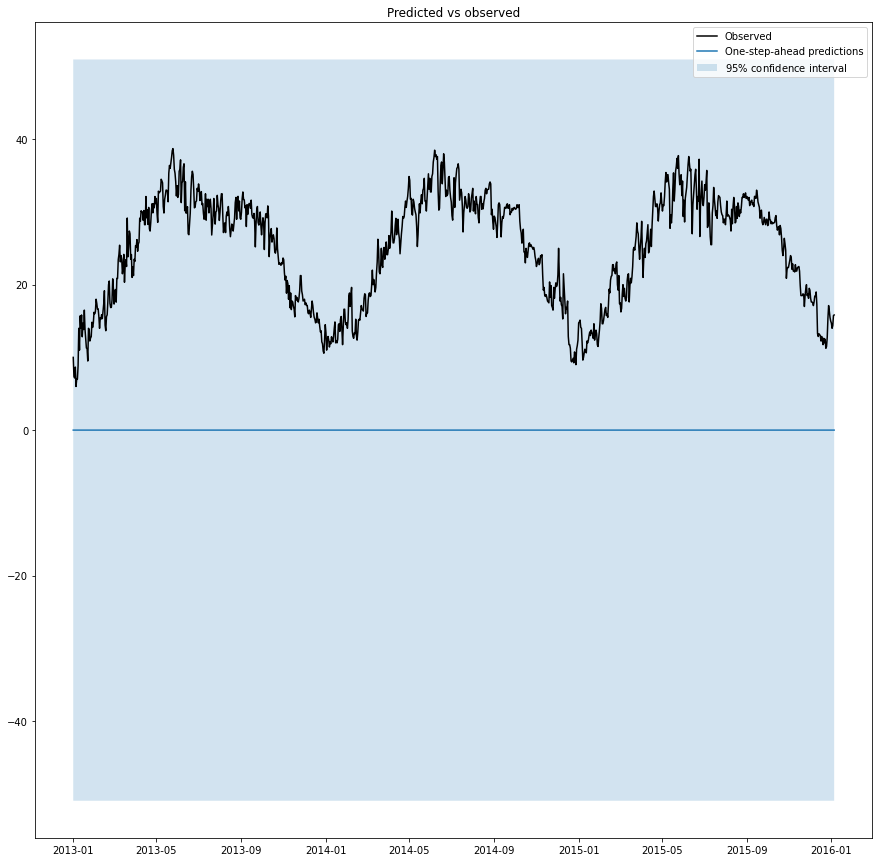

In [46]:
ucm_fitted.plot_components(figsize = (15, 15));

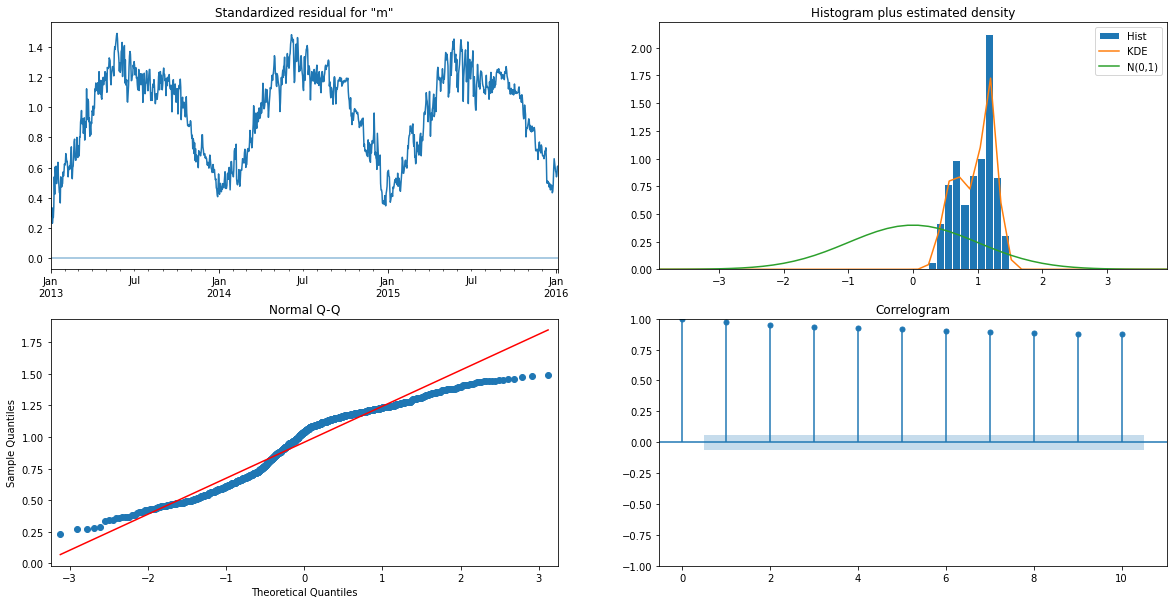

In [47]:
ucm_fitted.plot_diagnostics(figsize = (20,10));

In [48]:
residuals = ucm_fitted.resid
residuals.name = 'residuals'

df1.join(residuals)[['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'residuals']].corr()['residuals']

meantemp        1.000000
humidity       -0.587877
wind_speed      0.304302
meanpressure   -0.890866
residuals       1.000000
Name: residuals, dtype: float64

In [49]:
model = {

'level' : True,
'stochastic_level' : False,
    
'trend' : False,
'stochastic_trend' : False,
    
'seasonal' : None, #numerico indicando qual a sazonalidade
'freq_seasonal' : [{'period' : 364,
                   'harmonics' : 1},
                   {'period' : 29,
                   'harmonics' : 1}
                  ],
'stochastic_seasonal' : False,
'stochastic_freq_seasonal' : None,
    
'cycle' : False,
'stochastic_cycle' : False,
'damped_cycle' : False,
'cycle_period_bounds' : None,
    
'irregular' : 0,
'autoregressive' : 2 #Numero indicando ordem autoregressiva no erro
    
}

ucm = UnobservedComponents(df1['meantemp'].iloc[:1100], **model, exog = df1[['humidity', 'wind_speed']].iloc[:1100])
ucm_fitted = ucm.fit(method = 'powell', disp = False)

print('Resultados UCM | In Sample - One Step Ahead')

print('\n')
print('RMSE : ' + str(np.sqrt(ucm_fitted.mse)))
print('MAE : ' + str(ucm_fitted.mae))
print('\n')

ucm_fitted.summary()

Resultados UCM | In Sample - One Step Ahead


RMSE : 1.4011653833118949
MAE : 0.9354391991925155




<class 'statsmodels.iolib.summary.Summary'>
"""
                                Unobserved Components Results                                 
==============================================================================================
Dep. Variable:                               meantemp   No. Observations:                 1100
Model:                                fixed intercept   Log Likelihood               -1780.678
                   + stochastic freq_seasonal(364(1))   AIC                           3575.357
                    + stochastic freq_seasonal(29(1))   BIC                           3610.347
                                              + AR(2)   HQIC                          3588.597
Date:                                Sat, 11 Nov 2023                                         
Time:                                        23:40:58                                         
Sample:                                    01-01-2013                                         
                                         - 01-05-2016                                         
Covariance Type:                                  opg                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
sigma2.freq_seasonal_364(1)     0.0336      0.013      2.600      0.009       0.008       0.059
sigma2.freq_seasonal_29(1)      0.0006      0.001      0.895      0.371      -0.001       0.002
sigma2.ar                       1.3454      0.041     32.583      0.000       1.264       1.426
ar.L1                           0.7981      0.028     28.539      0.000       0.743       0.853
ar.L2                          -0.1057      0.028     -3.714      0.000      -0.162      -0.050
beta.humidity                  -0.1336      0.004    -34.315      0.000      -0.141      -0.126
beta.wind_speed                -0.0227      0.007     -3.123      0.002      -0.037      -0.008
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               604.23
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                            -0.35
Prob(H) (two-sided):                  0.20   Kurtosis:                         6.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

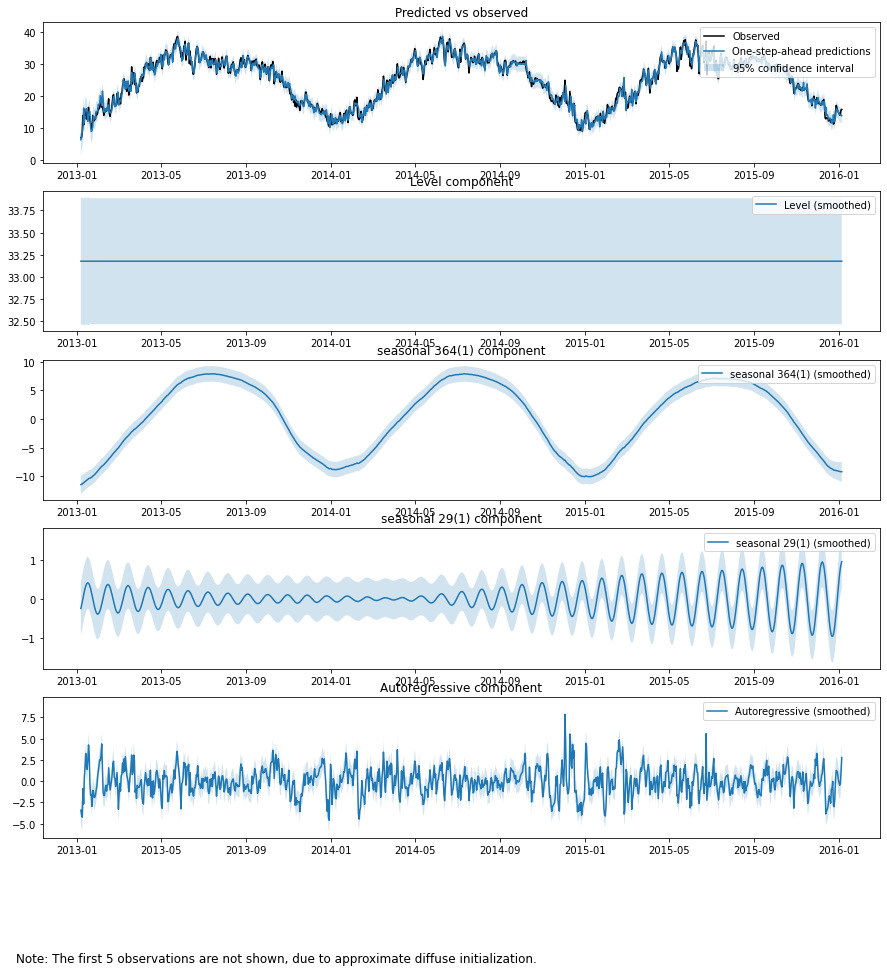

In [50]:
ucm_fitted.plot_components(figsize = (15, 15));

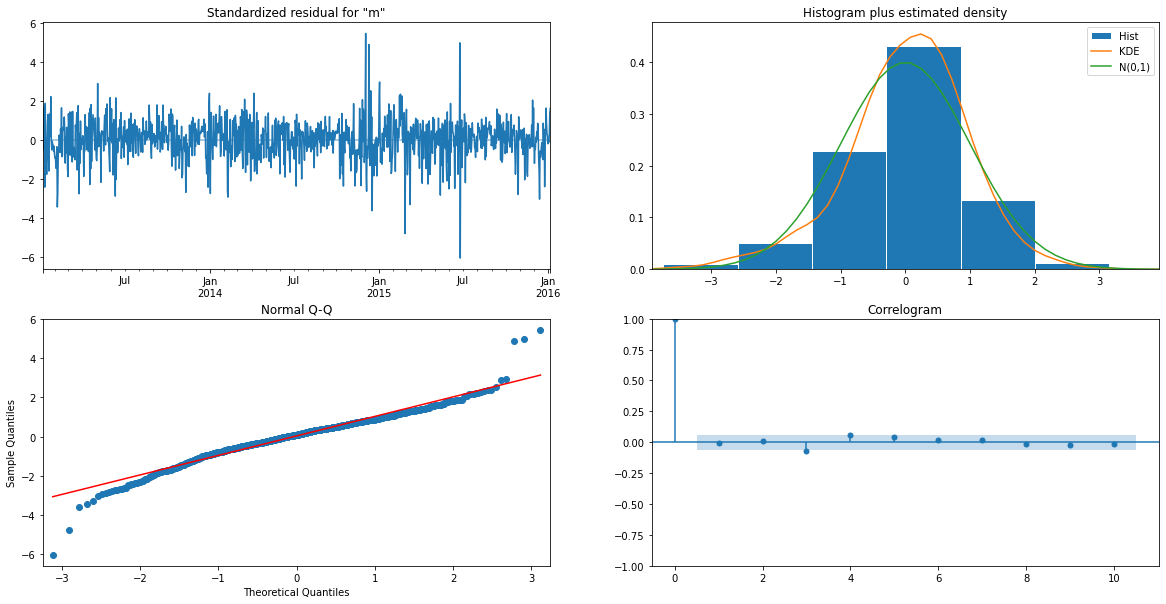

In [51]:
ucm_fitted.plot_diagnostics(figsize = (20,10));

In [52]:
residuals = ucm_fitted.resid
residuals.name = 'residuals'

df1.join(residuals)[['meantemp', 'humidity', 'wind_speed', 'meanpressure', 'residuals']].corr()['residuals']

meantemp        0.111781
humidity        0.024628
wind_speed     -0.070931
meanpressure   -0.065703
residuals       1.000000
Name: residuals, dtype: float64

# Performance UCM - Validação

In [53]:
predictions = df1['meantemp'].iloc[:1100]

for i in range(1100, 1462):

    ucm = UnobservedComponents(df1['meantemp'].iloc[:i], **model, exog = df1[['humidity', 'wind_speed']].iloc[:i])
    ucm_fitted = ucm.fit(method = 'powell', disp = False)

    forecast = ucm_fitted.forecast(exog = df1[['humidity', 'wind_speed']].iloc[i])

    predictions = pd.concat([predictions, forecast])
    
mae_ucm = (df1['meantemp'].iloc[1100:] - predictions.iloc[1100:]).abs().mean()

rmse_ucm = np.sqrt(  ( (df1['meantemp'].iloc[1100:] - predictions.iloc[1100:]) * (df1['meantemp'].iloc[1100:] - predictions.iloc[1100:]) ).mean() )

print('Resultados Validação - UCM')
print('RMSE : ' + str(rmse_ucm))
print('MAE : ' + str(mae_ucm))

Resultados Validação - UCM
RMSE : 1.1056254383631579
MAE : 0.8803216551620634


# Comparação de Performance com uma Decision Tree

- Construção de novas features para tentar fazer o modelo captar o comportamento histórico

In [54]:
df1['valor_t-1'] = df1['meantemp'].shift()
df1['valor_t-2'] = df1['meantemp'].shift(2)
df1['valor_t-3'] = df1['meantemp'].shift(3)

df1['diferenca_t-1'] = df1['meantemp'].shift().diff()


In [55]:
regressor.max_depth = 5

from sklearn.model_selection import cross_val_score
scores_rmse = cross_val_score(regressor, df1.iloc[5:,1:], df1['meantemp'].iloc[5:], cv = 50, scoring = 'neg_mean_squared_error')
rmse_decision_tree = np.sqrt(abs(scores_rmse.mean()))

scores_mae = cross_val_score(regressor, df1.iloc[5:,1:], df1['meantemp'].iloc[5:], cv = 50, scoring = 'neg_mean_absolute_error')
mae_decision_tree = abs(scores_mae.mean())

print('Resultados Validação - Decision Tree')
print('RMSE : ' + str(rmse_decision_tree))
print('MAE : ' + str(mae_decision_tree))

Resultados Validação - Decision Tree
RMSE : 1.6307239400132594
MAE : 1.2815292528437043


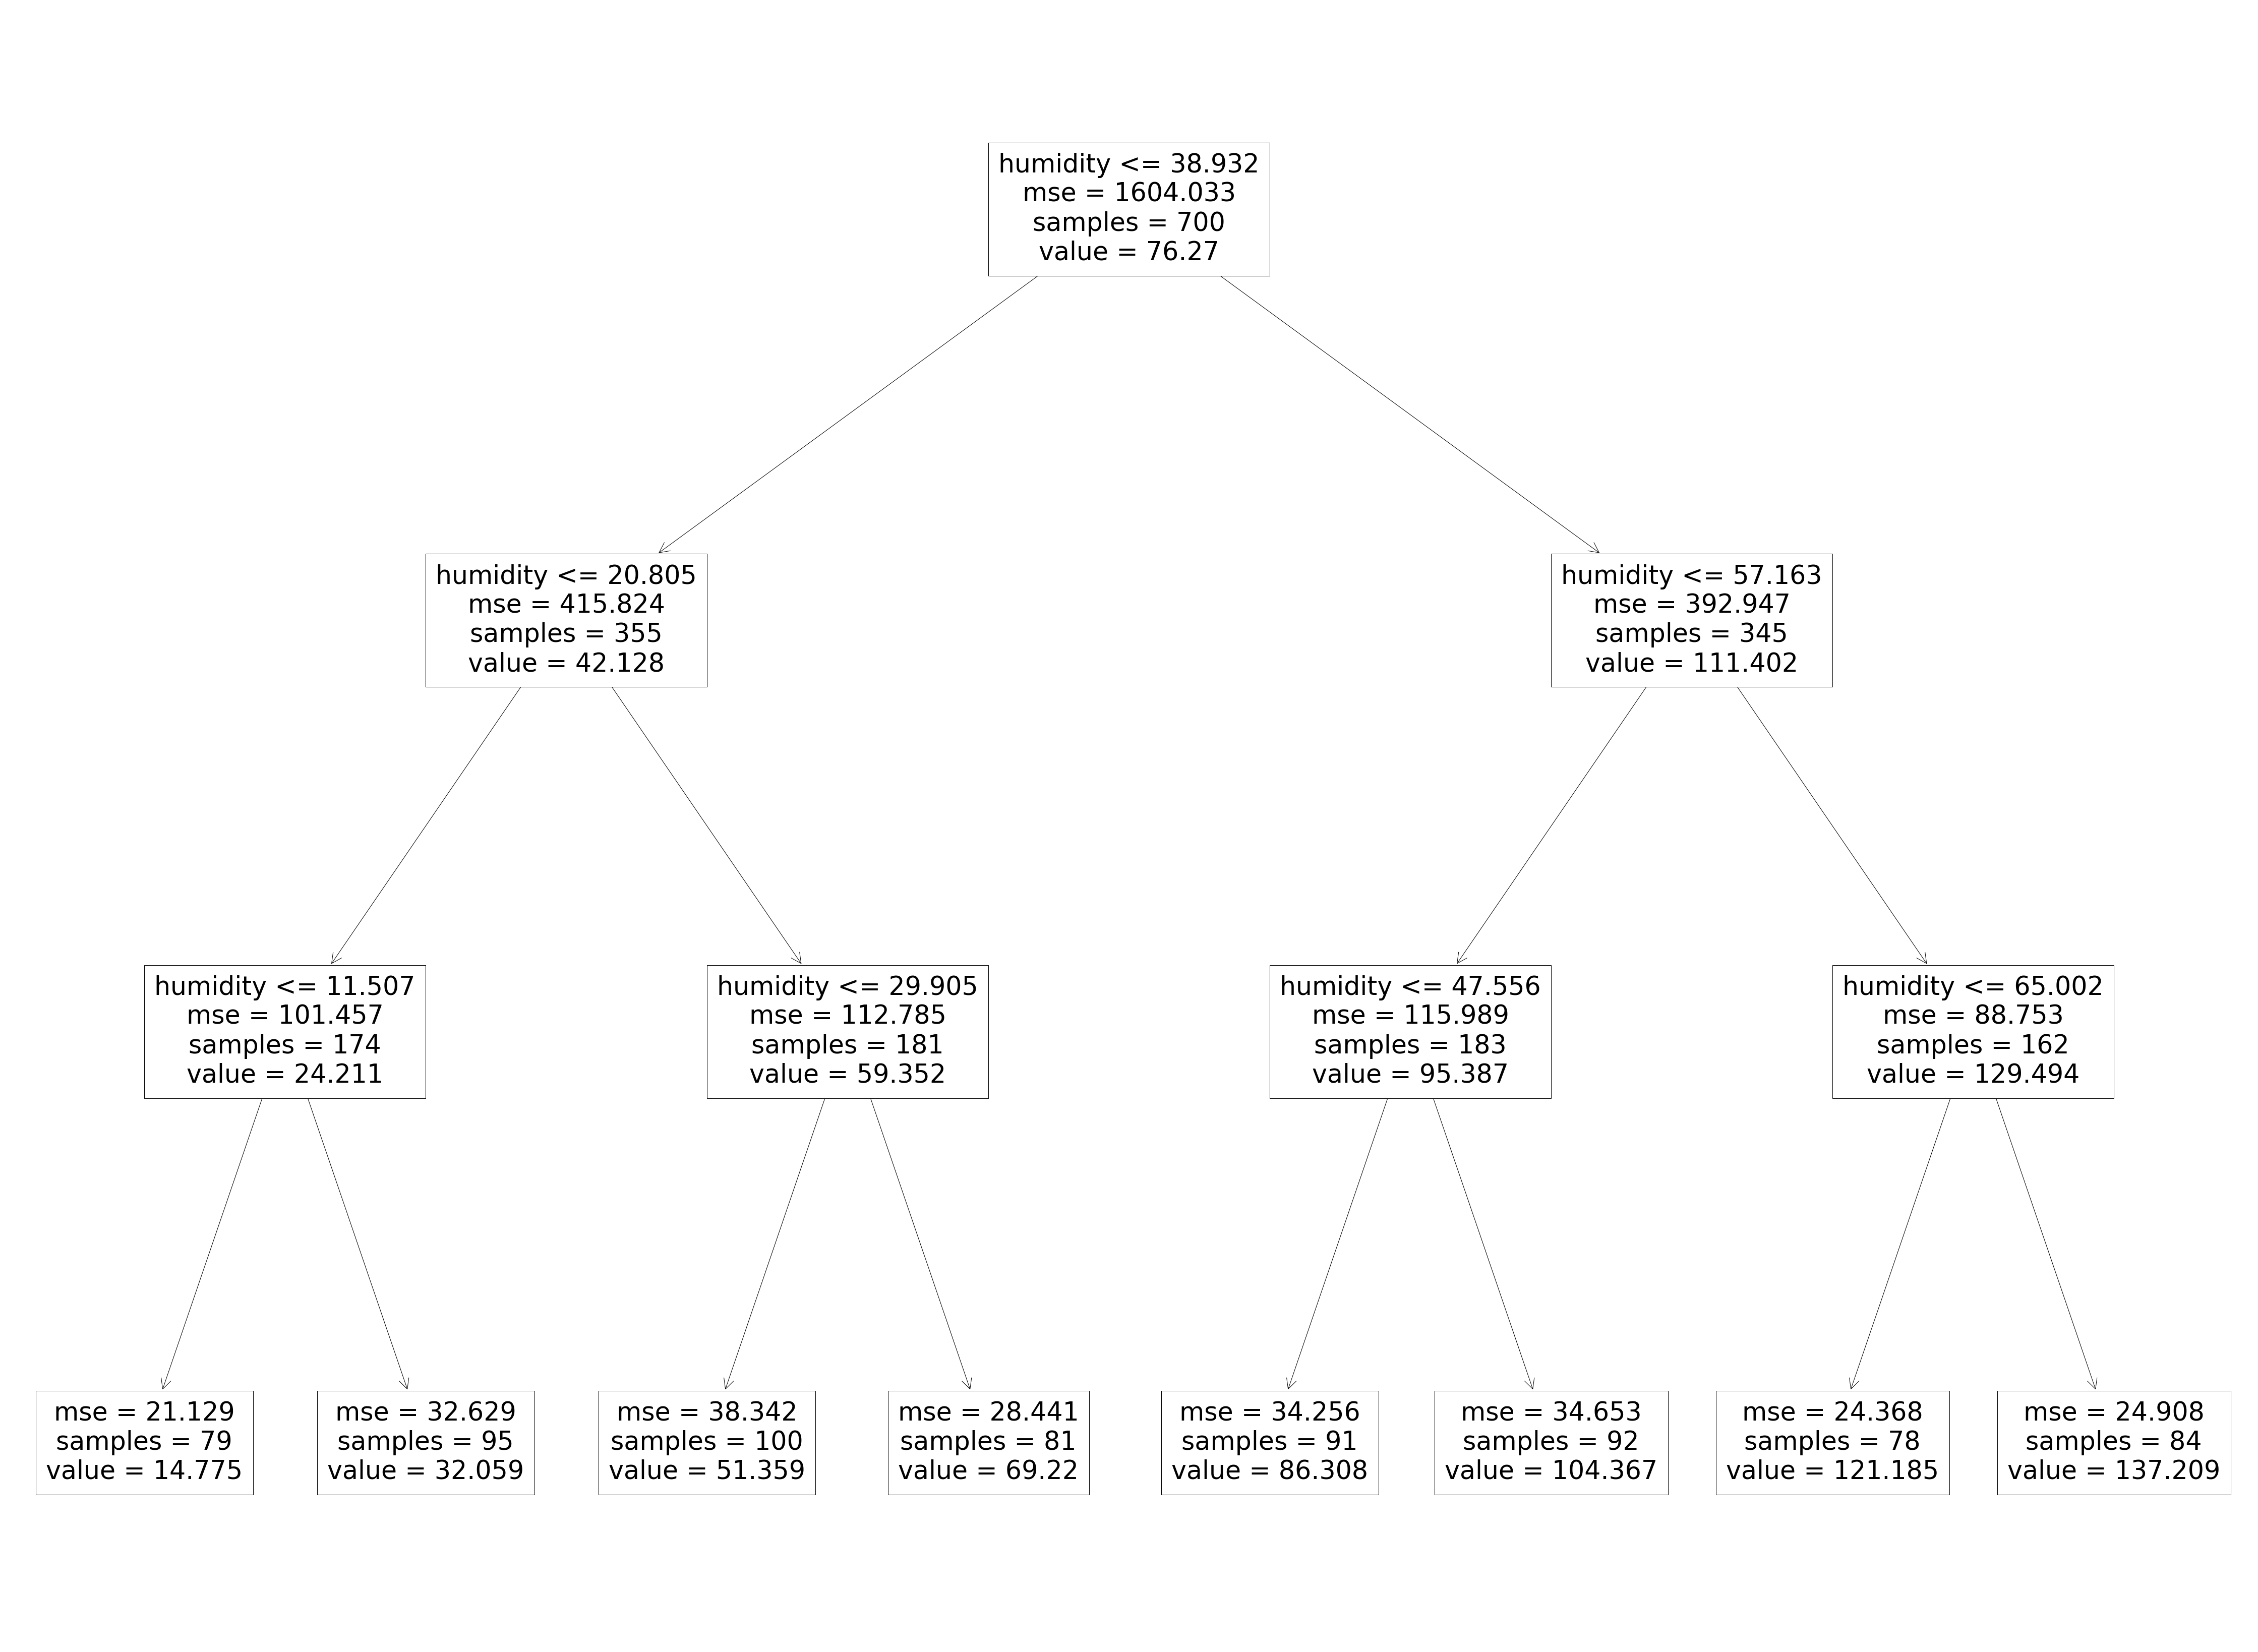

In [56]:
plt.figure(figsize = (80, 60))

tree.plot_tree(decision_tree = regressor, feature_names = df1.iloc[5:,1:].columns)
plt.show()

# Referencias

Sobre estacionariedade em séries temporais:

    Marcos Lopez de Prado - Advances in Financial Machine Learning


Sobre UCM:

    https://www.youtube.com/watch?v=v5ijNXvlC5A - Modern Time Series Analysis | SciPy 2019 Tutorial | Aileen Nielsen

    Pelagatti, Matteo M - Time series modelling with unobserved components

Sobre estimação multiplas sazonalidade utilizando componentes trigonometricos:

    https://www.statsmodels.org/devel/examples/notebooks/generated/statespace_seasonal.html

